# 01 Data Downloader & Cleanser for PubMed Journals

---

In [1]:
## Load common things
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## 1. Data Download

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## 2. Data Loader


In [3]:
def get_cached_data(filepath):
    with open(filepath) as f:
        return f.readlines()

---

#### `TO-DO`: Change the file path if on server!

In [4]:
cached_dataset_dir = 'pre-cached-dt/'

train_data = get_cached_data(cached_dataset_dir + 'train.txt')
train_file_path = cached_dataset_dir+'train.txt'
val_file_path = cached_dataset_dir+'val.txt'
test_file_path = cached_dataset_dir+'test.txt'

**Visual Inspection**: Just to see if it is loaded properly.

In [5]:
# View the first 5 lines from the training data
train_data[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n']

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n']

---

### 2.1 Data Separation

In order to prepare the dataset for the training of our neural network, several key preprocessing steps must be undertaken. These involve transforming the raw corpus of medical research articles into a format that our neural network can understand and learn from.

One of the essential steps in this preprocessing pipeline is to clearly delineate the beginning and end of each abstract within the overall corpus. This is crucial as each abstract represents a distinct unit of information, and these need to be distinctly identifiable for the machine learning algorithm. Mixing up the data from different abstracts can lead to inaccurate predictions and learning inaccuracies.

Thus, we must first identify where each abstract starts and where it ends in our data. This involves looking for specific markers or patterns that indicate the start and end of an abstract. Once we can accurately identify these markers, we can extract the abstract in its entirety as a distinct data point.

This "segmentation" of the corpus allows us to handle each abstract as an individual unit of analysis. By doing so, we ensure that the algorithm can accurately learn the structure and semantics of individual abstracts, rather than treating the entire corpus as one continuous piece of text. This is vital in our case, where each abstract represents a unique piece of research and should be treated as such.

**`TLDR`**: The goal of this stage of preprocessing is to convert the raw corpus into a structured dataset, where each row represents a unique abstract. This involves identifying the start and end of each abstract and then extracting the core content for analysis. This structured dataset is then ready to be used in training our neural network.

In [6]:
def data_separator(filepath):
    raw_data = get_cached_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in tqdm(raw_data):
        # See if the id is there, see the visual example above
        if line.startswith('###'):
            abstract_id = int(line.replace('###', '').replace('\n', ''))
            abstract_data = ''

        elif line.isspace(): # Find new line \n thingy
            abstract_data_split = abstract_data.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                
                # Fetch abstract ID
                line_data["abstract_id"] = abstract_id
                # Then, we index each line of the abstract
                line_data["line_id"] = f'{abstract_id}_{abstract_line_number}_{len(abstract_data_split)}'
                
                # Take the target portion out
                line_data["abstract_text"] = target_text_split[1]
                # Get the row index of the line
                line_data["line_number"] = abstract_line_number
                
                # Count total number of lines, and the indexing starts at 1
                line_data["total_lines"] = len(abstract_data_split)
                
                # Concat two things into one feature
                line_data['current_line'] = f'{abstract_line_number}_{len(abstract_data_split)}'
                
                # Create the label
                line_data["target"] = target_text_split[0]
                
                # Data can be transform and append together
                abstract_samples.append(line_data)

        else: # When format is not rigid
            abstract_data += line
            
    # Yield final lib of text
    return abstract_samples

Then, we use the function to get the training data ready.

In [7]:
# Get train data from file and preprocess it
# The path shall be defined at the beginning

if os.path.exists(train_file_path):
    print("The training file exists. Loading it again for pre-processing...")
    do_exist_train = True
    train_samples = data_separator(train_file_path)
else:
    do_exist_train = False
    print("The training file does not exist, please rewind!")

The training file exists. Loading it again for pre-processing...
The training file exists. Loading it again for pre-processing...


100%|██████████████████████████████████████████████████████████████████████| 210040/210040 [00:00<00:00, 641347.04it/s]



In [8]:
if os.path.exists(val_file_path):
    print("The validation file exists. Loading it again for pre-processing...")
    do_exist_val = True
    val_samples = data_separator(val_file_path)
else:
    do_exist_val = False
    print("The validation file does not exist, please rewind!")

The validation file exists. Loading it again for pre-processing...
The validation file exists. Loading it again for pre-processing...


100%|████████████████████████████████████████████████████████████████████████| 35212/35212 [00:00<00:00, 858706.75it/s]


In [9]:
if os.path.exists(test_file_path):
    print("The test file exists. Loading it again for pre-processing...")
    do_exist_test = True
    test_samples = data_separator(test_file_path)
else:
    do_exist_test = False
    print("The validation file does not exist, please rewind!")

The test file exists. Loading it again for pre-processing...
The test file exists. Loading it again for pre-processing...


100%|████████████████████████████████████████████████████████████████████████| 35135/35135 [00:00<00:00, 841202.33it/s]


Check if ready to move on.

In [10]:
if do_exist_test and do_exist_val and do_exist_train:
    print('Data loaded successfully!')
    print('# of training samples   = ', len(train_samples))
    print('# of validation samples = ', len(val_samples))
    print('# of test samples       = ', len(test_samples))
else:
    if not do_exist_test:
        print('Test data is missing! Please rewind!')
    if not do_exist_val:
        print('Validation data is missing! Please rewind!')
    if not do_exist_train:
        print('Training data is missing! Please rewind!')

Data loaded successfully!
# of training samples   =  180040
# of validation samples =  30212
# of test samples       =  30135
Data loaded successfully!
# of training samples   =  180040
# of validation samples =  30212
# of test samples       =  30135


---

### 2.2 Data Transformation for NN Training

Given that the current data is stored in a dictionary and a list, it is necessary to transform them into a pandas dataframe before proceeding with the training of the neural network. This transformation is required because the neural network typically expects the data to be in a tabular format with well-defined columns.

**`Visual Inspection`**: For safety purpose.

In [11]:
train_samples[:5]

[{'abstract_id': 24293578,
  'line_id': '24293578_0_12',
  'abstract_text': 'To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12,
  'current_line': '0_12',
  'target': 'OBJECTIVE'},
 {'abstract_id': 24293578,
  'line_id': '24293578_1_12',
  'abstract_text': 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 12,
  'current_line': '1_12',
  'target': 'METHODS'},
 {'abstract_id': 24293578,
  'line_id': '24293578_2_12',
  'abstract_text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12,

[{'abstract_id': 24293578,
  'line_id': '24293578_0_12',
  'abstract_text': 'To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12,
  'current_line': '0_12',
  'target': 'OBJECTIVE'},
 {'abstract_id': 24293578,
  'line_id': '24293578_1_12',
  'abstract_text': 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 12,
  'current_line': '1_12',
  'target': 'METHODS'},
 {'abstract_id': 24293578,
  'line_id': '24293578_2_12',
  'abstract_text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12,

In [12]:
val_samples[:5]

[{'abstract_id': 24290286,
  'line_id': '24290286_0_10',
  'abstract_text': 'IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_lines': 10,
  'current_line': '0_10',
  'target': 'BACKGROUND'},
 {'abstract_id': 24290286,
  'line_id': '24290286_1_10',
  'abstract_text': 'It is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 1,
  'total_lines': 10,
  'current_line': '1_10',
  'target': 'BACKGROUND'},
 {'abstract_id': 24290286,
  'line_id': '24290286_2_10',
  'abstract_text': 'We sought to determine whether a 3-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .',
  'line_number': 2,
  'total_lines': 10,
  'current_line': '2_10',
  'target': 'OBJECTIVE'},
 {'abstract_id': 24290286,
  'line_id': '24290286_3_10',
  'abstract_text': 'Asthmatic patients who were 

[{'abstract_id': 24290286,
  'line_id': '24290286_0_10',
  'abstract_text': 'IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_lines': 10,
  'current_line': '0_10',
  'target': 'BACKGROUND'},
 {'abstract_id': 24290286,
  'line_id': '24290286_1_10',
  'abstract_text': 'It is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 1,
  'total_lines': 10,
  'current_line': '1_10',
  'target': 'BACKGROUND'},
 {'abstract_id': 24290286,
  'line_id': '24290286_2_10',
  'abstract_text': 'We sought to determine whether a 3-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .',
  'line_number': 2,
  'total_lines': 10,
  'current_line': '2_10',
  'target': 'OBJECTIVE'},
 {'abstract_id': 24290286,
  'line_id': '24290286_3_10',
  'abstract_text': 'Asthmatic patients who were 

In [13]:
test_samples[:5]

[{'abstract_id': 24845963,
  'line_id': '24845963_0_9',
  'abstract_text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
  'line_number': 0,
  'total_lines': 9,
  'current_line': '0_9',
  'target': 'BACKGROUND'},
 {'abstract_id': 24845963,
  'line_id': '24845963_1_9',
  'abstract_text': 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
  'line_number': 1,
  'total_lines': 9,
  'current_line': '1_9',
  'target': 'RESULTS'},
 {'abstract_id': 24845963,
  'line_id': '24845963_2_9',
  'abstract_text': 'Liver function tests ( LFTs ) were measured at 7 time points from baseline , at discharge , and up to 6 months follow-up .',
  'line_number': 2,
  'total_lines': 9,
  'current_line': '2_9',
  'target': 'RESULTS'},
 {'abstract_id': 24845963,
  'line_id': '24845963_3_9',
  '

[{'abstract_id': 24845963,
  'line_id': '24845963_0_9',
  'abstract_text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
  'line_number': 0,
  'total_lines': 9,
  'current_line': '0_9',
  'target': 'BACKGROUND'},
 {'abstract_id': 24845963,
  'line_id': '24845963_1_9',
  'abstract_text': 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
  'line_number': 1,
  'total_lines': 9,
  'current_line': '1_9',
  'target': 'RESULTS'},
 {'abstract_id': 24845963,
  'line_id': '24845963_2_9',
  'abstract_text': 'Liver function tests ( LFTs ) were measured at 7 time points from baseline , at discharge , and up to 6 months follow-up .',
  'line_number': 2,
  'total_lines': 9,
  'current_line': '2_9',
  'target': 'RESULTS'},
 {'abstract_id': 24845963,
  'line_id': '24845963_3_9',
  '

Now we convert them all into dataframes.

In [14]:
# Deadly simple
df_train = pd.DataFrame(train_samples)
df_val = pd.DataFrame(val_samples)
df_test = pd.DataFrame(test_samples)

**`Visual Inspection`**: For safety purpose.

In [15]:
df_train.head(5)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,0_12,OBJECTIVE
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,1_12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,2_12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,4_12,METHODS


,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,0_12,OBJECTIVE
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,1_12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,2_12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,4_12,METHODS


In [16]:
df_val.head(5)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24290286,24290286_0_10,IgE sensitization to Aspergillus fumigatus and...,0,10,0_10,BACKGROUND
1,24290286,24290286_1_10,It is not clear whether these patients would b...,1,10,1_10,BACKGROUND
2,24290286,24290286_2_10,We sought to determine whether a 3-month cours...,2,10,2_10,OBJECTIVE
3,24290286,24290286_3_10,Asthmatic patients who were IgE sensitized to ...,3,10,3_10,METHODS
4,24290286,24290286_4_10,Primary outcomes were improvement in quality o...,4,10,4_10,METHODS


,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24290286,24290286_0_10,IgE sensitization to Aspergillus fumigatus and...,0,10,0_10,BACKGROUND
1,24290286,24290286_1_10,It is not clear whether these patients would b...,1,10,1_10,BACKGROUND
2,24290286,24290286_2_10,We sought to determine whether a 3-month cours...,2,10,2_10,OBJECTIVE
3,24290286,24290286_3_10,Asthmatic patients who were IgE sensitized to ...,3,10,3_10,METHODS
4,24290286,24290286_4_10,Primary outcomes were improvement in quality o...,4,10,4_10,METHODS


In [17]:
df_test.head(5)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS


,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS


In the `training data`, let's see how many labels we have.

In [18]:
label_counts = df_train['target'].value_counts()
label_counts = label_counts.sort_index(ascending=True)
label_counts

BACKGROUND     21727
CONCLUSIONS    27168
METHODS        59353
OBJECTIVE      13839
RESULTS        57953
Name: target, dtype: int64

BACKGROUND     21727
CONCLUSIONS    27168
METHODS        59353
OBJECTIVE      13839
RESULTS        57953
Name: target, dtype: int64

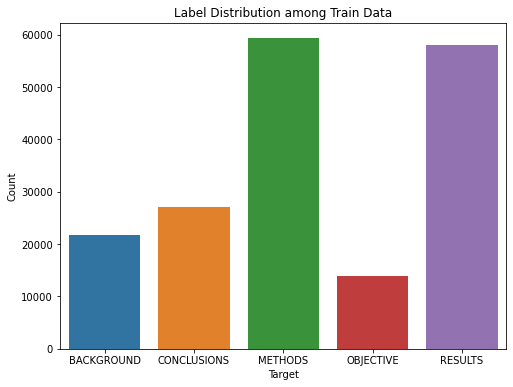

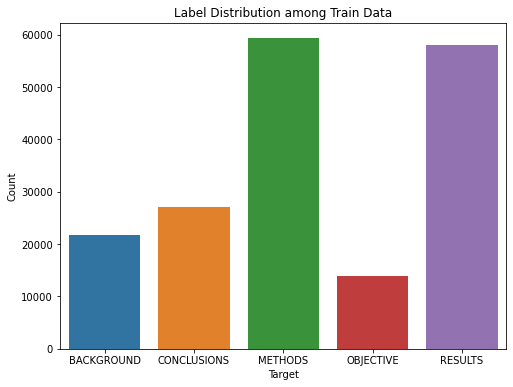

In [19]:
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Label Distribution among Train Data')
plt.show()

In the `validation data`, let's see how many labels we have.

In [20]:
label_counts = df_val['target'].value_counts()
label_counts = label_counts.sort_index(ascending=True)
label_counts

BACKGROUND     3449
CONCLUSIONS    4582
METHODS        9964
OBJECTIVE      2376
RESULTS        9841
Name: target, dtype: int64

BACKGROUND     3449
CONCLUSIONS    4582
METHODS        9964
OBJECTIVE      2376
RESULTS        9841
Name: target, dtype: int64

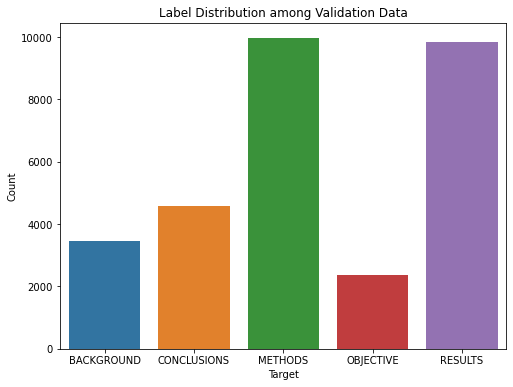

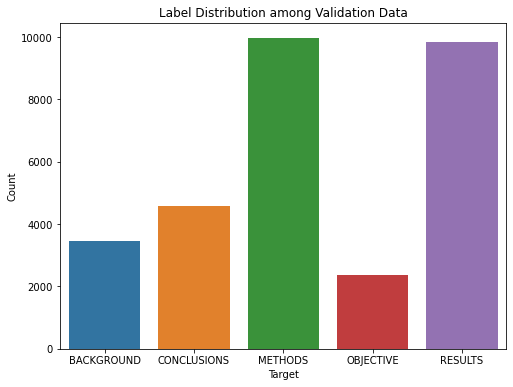

In [21]:
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Label Distribution among Validation Data')
plt.show()

In the `test data`, let's see how many labels we have.

In [22]:
label_counts = df_test['target'].value_counts()
label_counts = label_counts.sort_index(ascending=True)
label_counts

BACKGROUND     3621
CONCLUSIONS    4571
METHODS        9897
OBJECTIVE      2333
RESULTS        9713
Name: target, dtype: int64

BACKGROUND     3621
CONCLUSIONS    4571
METHODS        9897
OBJECTIVE      2333
RESULTS        9713
Name: target, dtype: int64

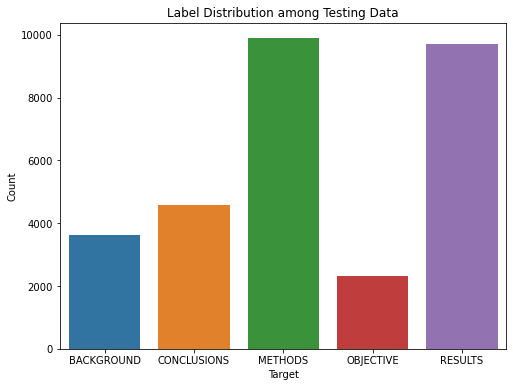

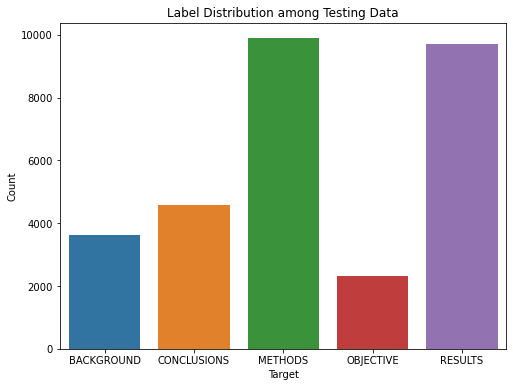

In [23]:
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Label Distribution among Testing Data')
plt.show()

_**Well**_, the distributions of labels among train, val, test are not perfect. We could possible shuffle things around or get a better cut of the dataset. Let's see if it is needed to optimize the data stream.

---

### 2.3 Input Sequence Construction

Since we have already transformed our dataset into usable pandas dataframe, now we need to construct the data pipeline for input of the neural network model.

To construct the data pipeline for the input of the neural network model using the transformed pandas dataframe, we need to transform the usable portion back to list.

In [24]:
try:
    train_sentences = df_train["abstract_text"].tolist()
    print('Train input list success!')
except Exception as e:
    print("Error encountered! Please rewind!")
    print(e)

Train input list success!
Train input list success!


In [25]:
try:
    val_sentences = df_val["abstract_text"].tolist()
    print('Validation input list success!')
except Exception as e:
    print("Error encountered! Please rewind!")
    print(e)

Validation input list success!
Validation input list success!


In [26]:
try:
    test_sentences = df_test["abstract_text"].tolist()
    print('Testing input list success!')
except Exception as e:
    print("Error encountered! Please rewind!")
    print(e)

Testing input list success!
Testing input list success!


Check the size of the dataset.

In [27]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)

In [28]:
print('# of sentences for training   = ', train_sentences_count)
print('# of sentences for validation = ', val_sentences_count)
print('# of sentences for testing    = ', test_sentences_count)

total_sentences_count = len(train_sentences) + len(val_sentences) + len(test_sentences)
print('# of sentences for total      = ', total_sentences_count)

# of sentences for training   =  180040
# of sentences for validation =  30212
# of sentences for testing    =  30135
# of sentences for total      =  240387
# of sentences for training   =  180040
# of sentences for validation =  30212
# of sentences for testing    =  30135
# of sentences for total      =  240387


**`Visual Inspection`**: For safety purpose.

In [29]:
train_sentences[:5]

['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .']

['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .']

In [30]:
val_sentences[:5]

['IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'It is not clear whether these patients would benefit from antifungal treatment .',
 'We sought to determine whether a 3-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .',
 'Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least 2 severe exacerbations in the previous 12 months were treated for 3 months with 200 mg of voriconazole twice daily , followed by observation for 9 months , in a double-blind , placebo-controlled , randomized design .',
 'Primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the 12 months of the study .']

['IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'It is not clear whether these patients would benefit from antifungal treatment .',
 'We sought to determine whether a 3-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .',
 'Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least 2 severe exacerbations in the previous 12 months were treated for 3 months with 200 mg of voriconazole twice daily , followed by observation for 9 months , in a double-blind , placebo-controlled , randomized design .',
 'Primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the 12 months of the study .']

In [31]:
test_sentences[:5]

['This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
 'Liver function tests ( LFTs ) were measured at 7 time points from baseline , at discharge , and up to 6 months follow-up .',
 'Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin 23.8 % , aspartate transaminase 23.5 % , alanine transaminase 23.8 % , and total bilirubin 36.1 % ) .',
 "The percentage of patients with abnormal LFTs decreased significantly from baseline to 6-months ' follow-up ."]

['This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
 'Liver function tests ( LFTs ) were measured at 7 time points from baseline , at discharge , and up to 6 months follow-up .',
 'Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin 23.8 % , aspartate transaminase 23.5 % , alanine transaminase 23.8 % , and total bilirubin 36.1 % ) .',
 "The percentage of patients with abnormal LFTs decreased significantly from baseline to 6-months ' follow-up ."]

---

## 3. Neural Network Construction

Now, we are ready to train our corpus.

### 3.1 Encoding

We use the `OneHotEncoder` from `scikit-learn` since it is just fast and convenient.

In [32]:
# !pip install scikit-learn scipy

In [115]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from sklearn.metrics import accuracy_score, balanced_accuracy_score, top_k_accuracy_score, average_precision_score, f1_score, matthews_corrcoef, classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

In [34]:
one_hot_encoder = OneHotEncoder(sparse=False)

Perform encoding on the labels.

In [35]:
one_hot_encoder_train_labels = one_hot_encoder.fit_transform(df_train["target"].to_numpy().reshape(-1, 1))
one_hot_encoder_val_labels = one_hot_encoder.transform(df_val["target"].to_numpy().reshape(-1, 1))
one_hot_encoder_test_labels = one_hot_encoder.transform(df_test["target"].to_numpy().reshape(-1, 1))

C:\Users\nkyam\miniforge3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\nkyam\miniforge3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**`Visual Inspection`**: For safety purpose.

In [36]:
one_hot_encoder_train_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [37]:
df_train["target"][0]

'OBJECTIVE'

'OBJECTIVE'

In [38]:
one_hot_encoder_train_labels.shape

(180040, 5)

(180040, 5)

Do the same thing with the labels.

In [39]:
label_encoder = LabelEncoder()

In [40]:
encoded_train_labels = label_encoder.fit_transform(df_train["target"].to_numpy())
encoded_val_labels = label_encoder.transform(df_val["target"].to_numpy())
encoded_test_labels = label_encoder.transform(df_test["target"].to_numpy())

**`Visual Inspection`**: For safety purpose.

In [41]:
encoded_train_labels

array([3, 2, 2, ..., 4, 1, 1])

array([3, 2, 2, ..., 4, 1, 1])

In [42]:
encoded_train_labels.shape

(180040,)

(180040,)

In [43]:
# Take out class names
number_label_class = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [44]:
print('# of classes = ', number_label_class, '\t (should expect 5)')

# of classes =  5 	 (should expect 5)
# of classes =  5 	 (should expect 5)


In [45]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

Now we deal with the lines.

In [46]:
line_one_hot_encoder = OneHotEncoder(sparse=False)

In [47]:
# from tqdm import tqdm

# train_lines_encoded = []
# total_samples = len(df_train["current_line"])

# for line in tqdm(df_train["current_line"].to_numpy().reshape(-1, 1), total=total_samples):
#     encoded_line = line_one_hot_encoder.fit_transform(line).astype(np.float32)
#     train_lines_encoded.append(encoded_line)

# train_lines_encoded = np.concatenate(train_lines_encoded, axis=0)


In [48]:
train_lines_encoded = line_one_hot_encoder.fit_transform(df_train["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

C:\Users\nkyam\miniforge3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\nkyam\miniforge3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [49]:
val_lines_encoded = line_one_hot_encoder.transform(df_val["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

In [50]:
test_lines_encoded = line_one_hot_encoder.transform(df_test["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

**`Visual Inspection`**: For safety purpose.

In [51]:
train_lines_encoded

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [52]:
train_lines_encoded.shape

(180040, 460)

(180040, 460)

In [53]:
val_lines_encoded.shape

(30212, 460)

(30212, 460)

In [54]:
test_lines_encoded.shape

(30135, 460)

(30135, 460)

In [55]:
# Check if the shapes are matchable
if train_lines_encoded.shape[1] == val_lines_encoded.shape[1] and val_lines_encoded.shape[1] == test_lines_encoded.shape[1]:
    print('Encoded just fine!')
else:
    print('Error occured, please rewind!')

Encoded just fine!
Encoded just fine!


### 3.2 Smoothing [Optinal]

This is optional, but can help.

> https://subscription.packtpub.com/book/data/9781838829131/12/ch12lvl1sec86/using-label-smoothing-to-increase-performance



In [56]:
def line_smoothing(line_one_hot_encoded, esp):
    return np.abs(line_one_hot_encoded - esp)

def undo_smoothing(smoothed_line_one_hot_encoded, esp):
    rewinder = smoothed_line_one_hot_encoded
    
    rewinder[rewinder>esp] = 1.0
    rewinder[rewinder<=esp] = 0.0
    
    return rewinder

In [57]:
train_lines_encoded = line_smoothing(train_lines_encoded, 0.01)

In [58]:
train_lines_encoded.shape

(180040, 460)

(180040, 460)

---

### 3.3 Create Data Pipeline

In [59]:
# !pip install tensorflow_hub

In [60]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [61]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with features and labels
    dataset_block = tf.data.Dataset.from_tensor_slices((features, labels))
    
    # Apply shuffling based on condition
    if shuffle:
        dataset_block = dataset_block.shuffle(buffer_size=1000)
        
    # Apply batching
    dataset_block = dataset_block.batch(batch_size)
    
    # Only when small mem on laptop
    if cache:
        dataset_block = dataset_block.cache(buffer_size=AUTOTUNE)
    
    # Should be fine with server
    if prefetch:
        dataset_block = dataset_block.prefetch(buffer_size=AUTOTUNE)
    
    return dataset_block

#### `TO-DO`: Change batch size based on need.

In [62]:
BATCH_SIZE = 32

In [63]:
train_features = (train_sentences, train_lines_encoded.astype(np.float32)) 
train_labels = one_hot_encoder_train_labels.astype(np.float32)

In [64]:
train_pipes = create_pipeline(
    train_features, train_labels, 
    batch_size=BATCH_SIZE, shuffle=True, 
    cache=False, prefetch=True)

In [65]:
val_features = (val_sentences, val_lines_encoded.astype(np.float32)) 
val_labels = one_hot_encoder_val_labels.astype(np.float32)

In [66]:
val_pipes = create_pipeline(val_features, val_labels, 
                         batch_size=BATCH_SIZE, shuffle=False, 
                         cache=False, prefetch=True)

In [67]:
test_features = (test_sentences, test_lines_encoded.astype(np.float32)) 
test_labels = one_hot_encoder_test_labels.astype(np.float32)

In [68]:
test_pipes = create_pipeline(test_features, test_labels, 
                          batch_size=BATCH_SIZE, shuffle=False, 
                          cache=False, prefetch=True)

**`Visual Inspection`**: For safety purpose.

In [69]:
train_pipes

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [70]:
val_pipes 

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [71]:
test_pipes


<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [72]:
temp_counter = 0
for data in test_pipes:
    if temp_counter < 1:
        # Print
        print(data)
        temp_counter = temp_counter + 1
    else:
        break

((<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
       b'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
       b'Liver function tests ( LFTs ) were measured at 7 time points from baseline , at discharge , and up to 6 months follow-up .',
       b'Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin 23.8 % , aspartate transaminase 23.5 % , alanine transaminase 23.8 % , and total bilirubin 36.1 % ) .',
       b"The percentage of patients with abnormal LFTs decreased significantly from baseline to 6-months '

---

### 3.4 Model Download

In [73]:
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [74]:
# get Universal Sentence Encoder here
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only 

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

In [75]:
class SelfAttentionBlock(layers.Layer):
    
    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)
        
        self.query = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, 
                                 return_sequences=True, name=f'block_query_lstm')
        
        self.value = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, go_backwards=True, 
                                 return_sequences=True, name=f'block_value_lstm')
        
        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')
        
        
    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)
        
        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)
        
        # Apply self-attention to LSTM 
        block_attention = self.attention([block_query, block_value])
        
        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D 
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)
        
        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)
        
        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])
        
        return block_residual

In [76]:
def build_model():
    # Model Inputs
    #------------
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')    
#     abstract_current_line = layers.Input(shape=(1017), dtype=tf.float32, name='abstract_current_line')
    abstract_current_line = layers.Input(shape=(460), dtype=tf.float32, name='abstract_current_line')
    
    # Define Layer Initializer
    #------------
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding
    #------------
    abstract_embedding = encoder(abstract_input)
    
    # Self Attention Block Stream
    #------------
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])
    
    # Current Line Stream
    #------------
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    #------------
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    #------------
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input, 
                                  abstract_current_line], 
                          outputs=[output_layer], name="use_attention_model")

**Before training process, make sure to check the model.**

In [77]:
# Build model
model = build_model()

In [78]:
model.summary()

Model: "use_attention_model"
__________________________________________________________________________________________________
Model: "use_attention_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Layer (type)                   Output Shape         Param #     Connected to                     
 abstract_text_input (InputLaye  [(None,)]           0           []                               
 abstract_text_input (InputLaye  [(None,)]           0           []                               
 r)                                                                                               
 r)                                                                                               
                                                                                                  
                                                   

                                                                  'dense[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 32)           0           ['dense_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 96)           0           ['mul_residual[0][0]',           
                                                                  'dropout[0][0]']                
                                                                                                  
                                                                                                  
 dropout (Dropout)              (None, 32)           0           ['dense_1[0][0]']                
                                                                                                  
 concatena

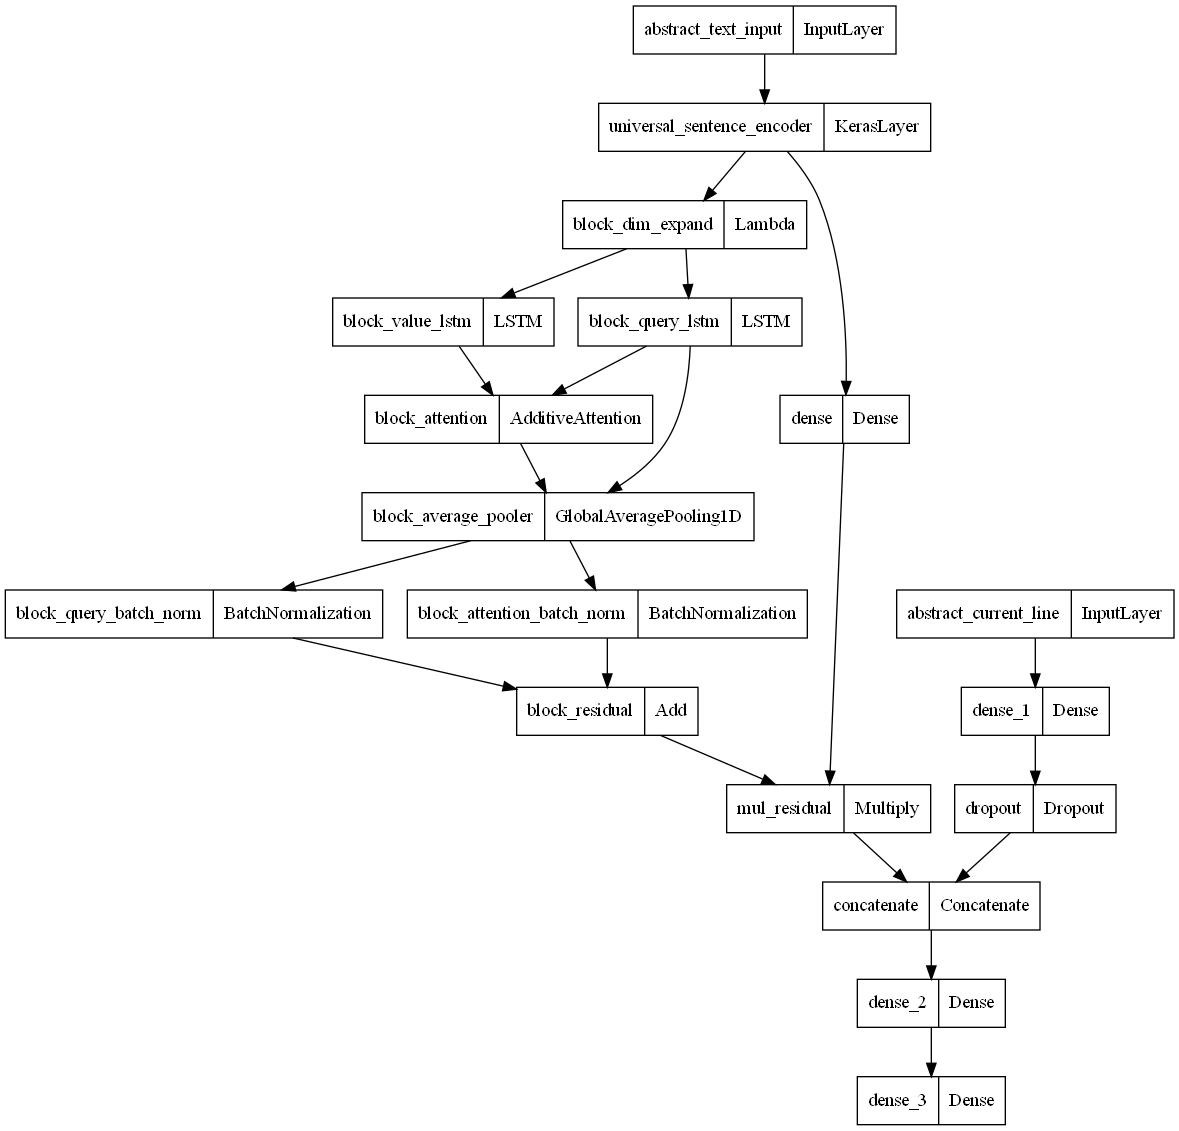

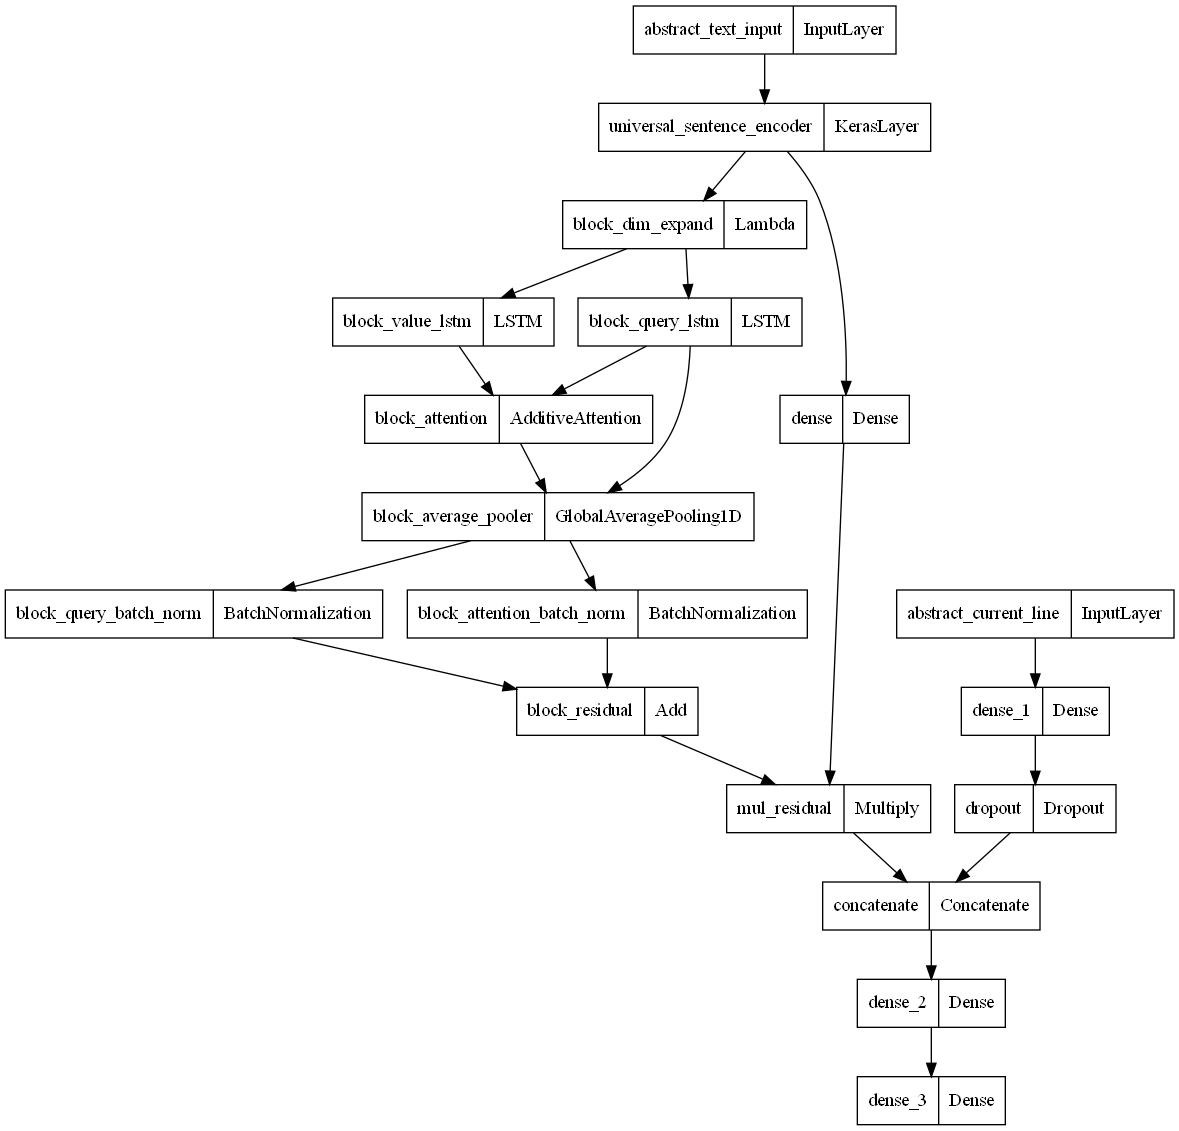

In [79]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png')


---

In case it is not rendering! Also, run the following on Linux:

```bash
sudo apt-get install graphviz
```

---

### 3.5 Model Training

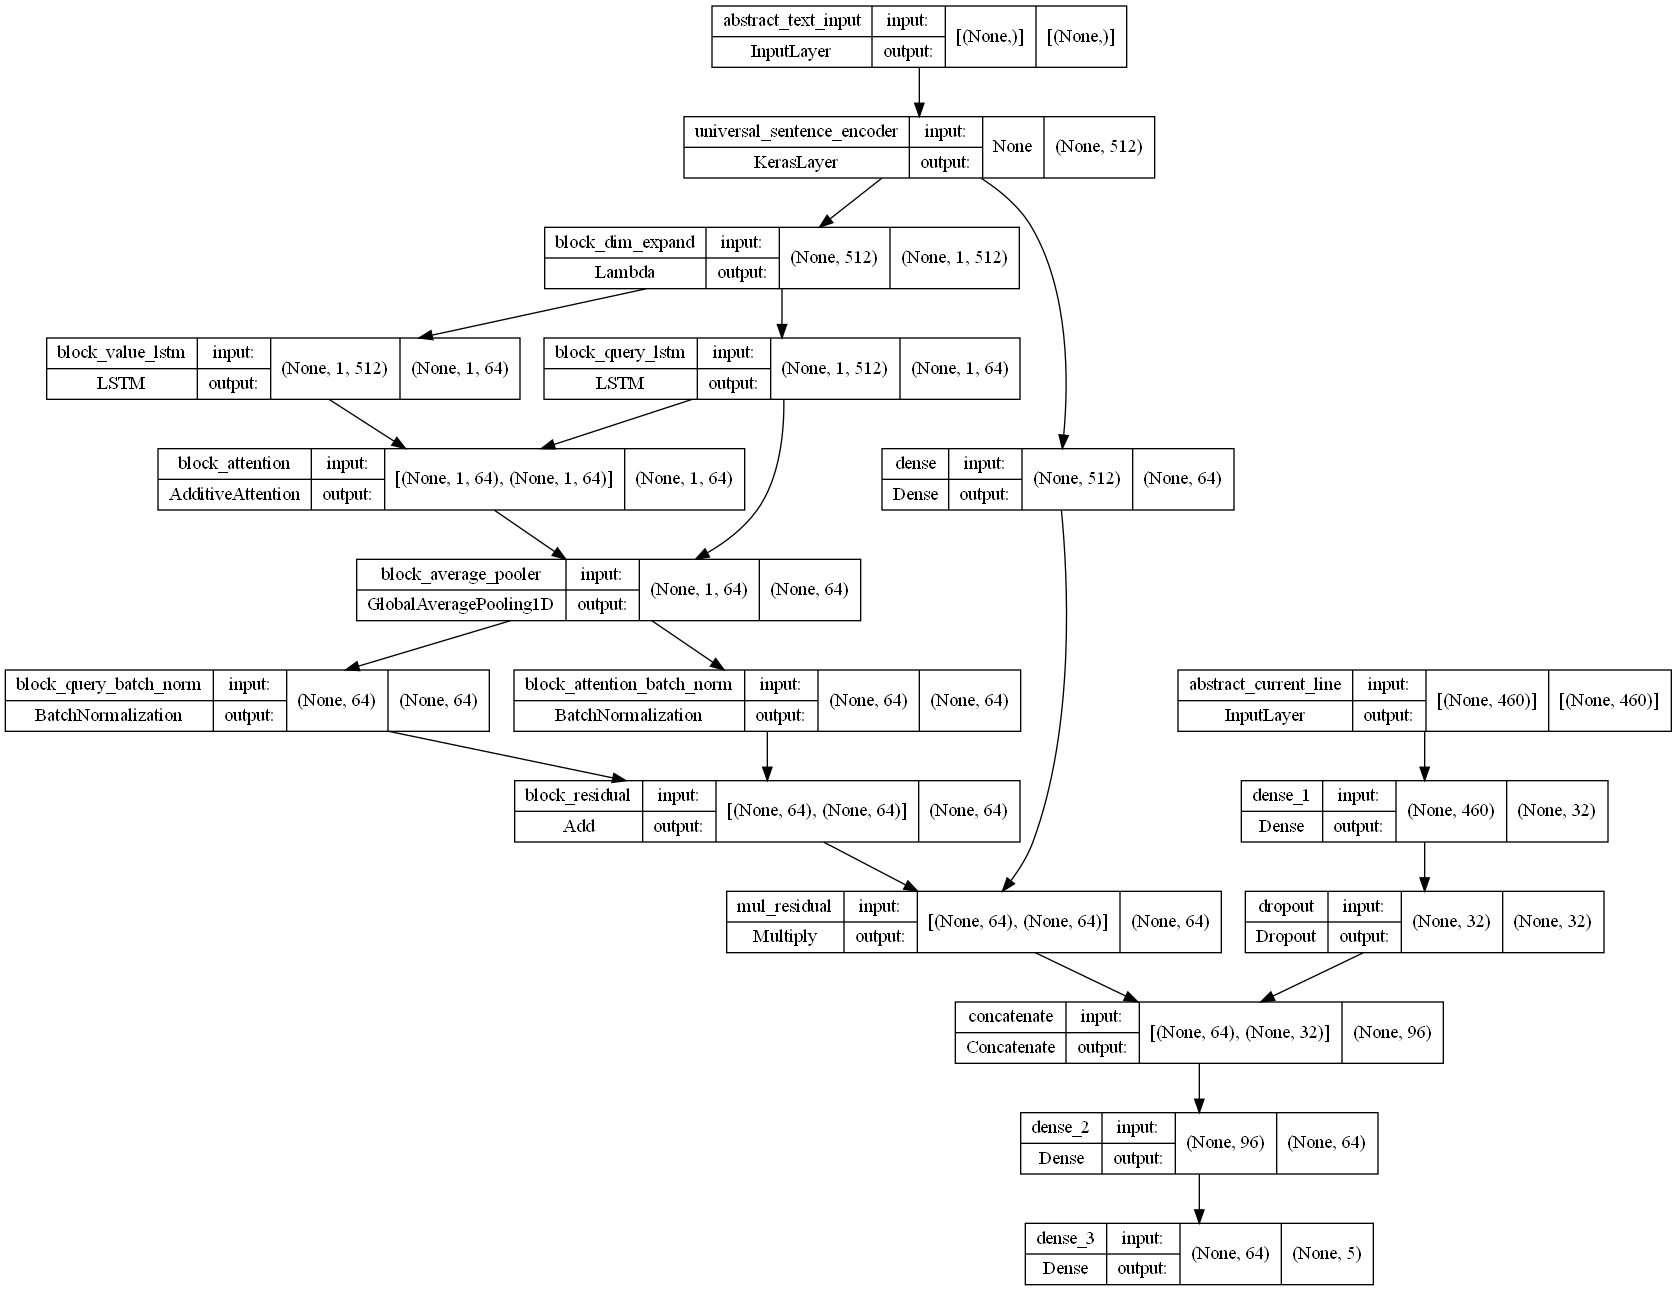

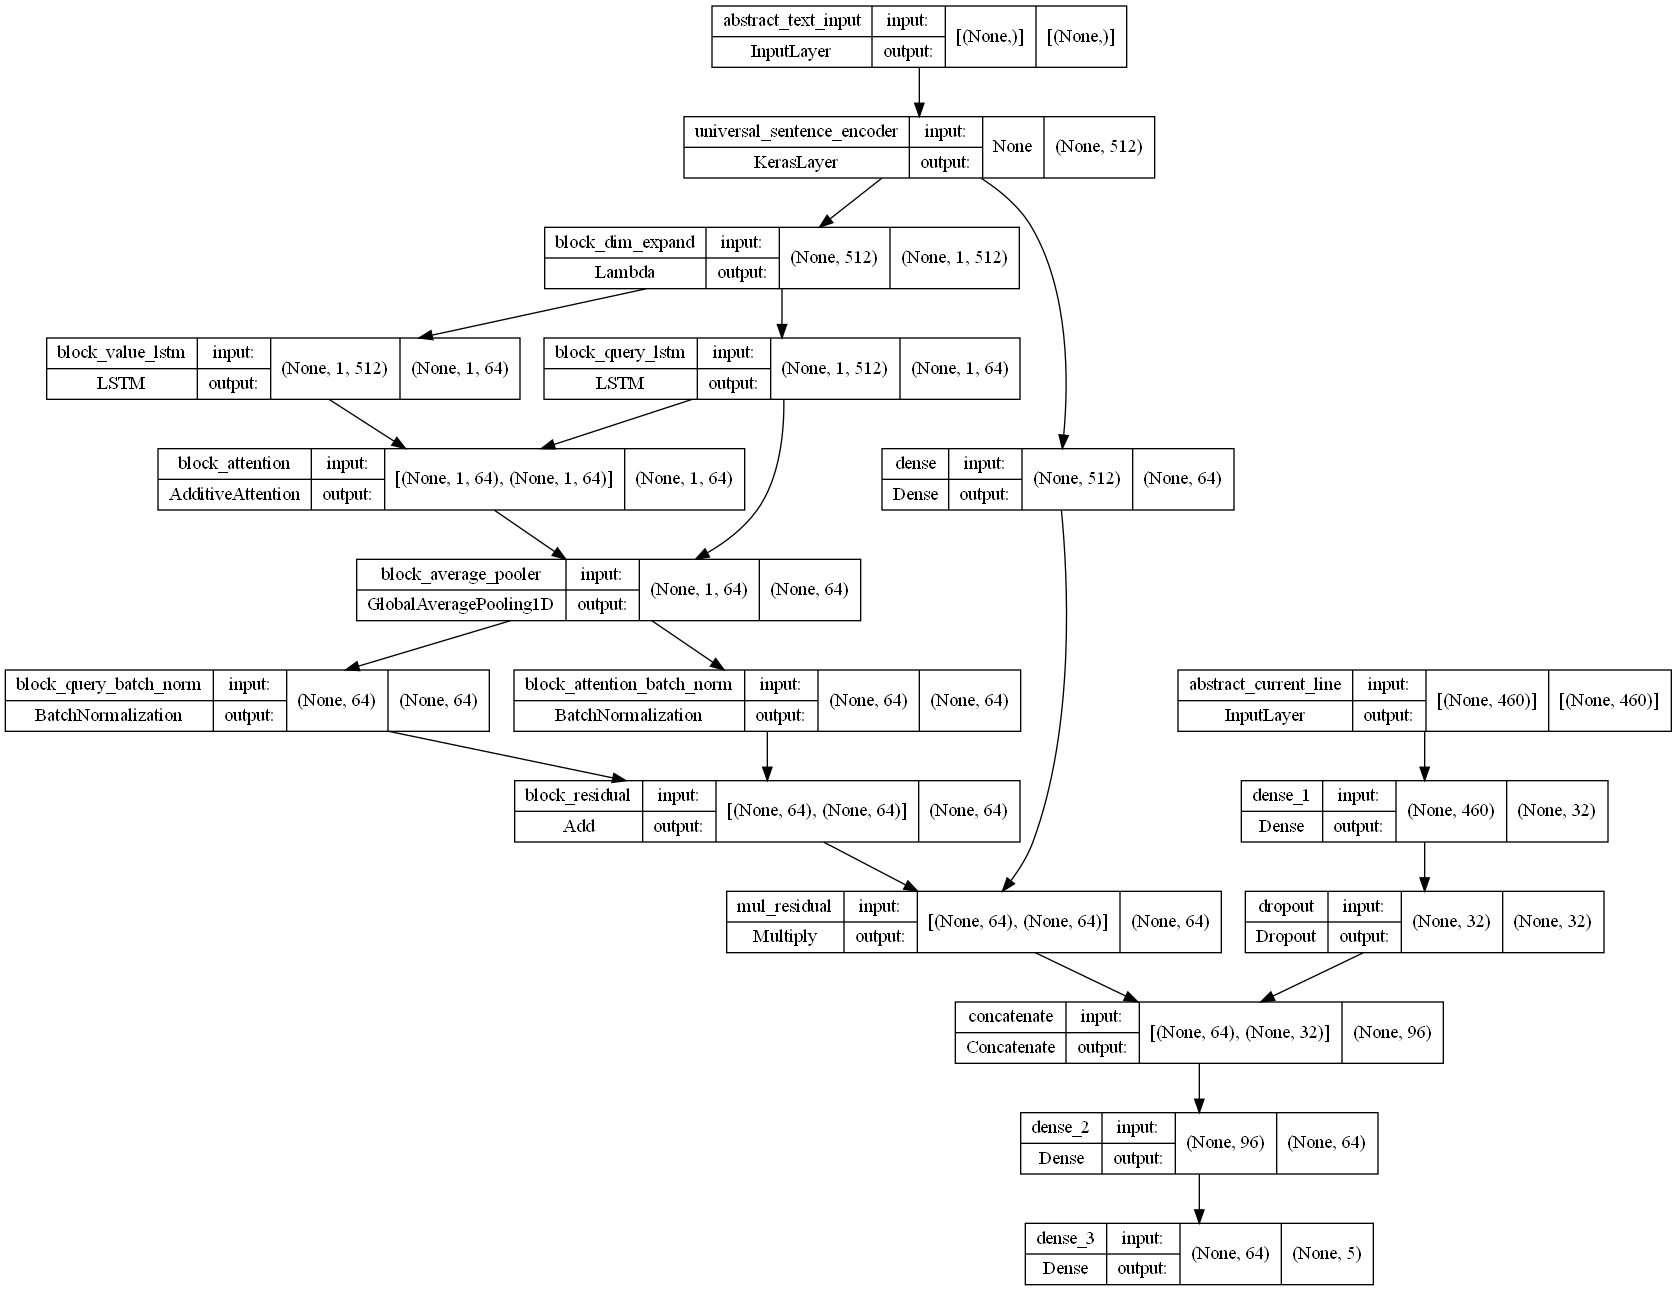

In [80]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model.png')


In [81]:
%load_ext tensorboard
import datetime
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)


In [82]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

We want to utilize early stopping to find the taper point in the training process.

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [83]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 20
CALLBACKS = [early_stopping_callback, reduce_lr_callback, tensorboard_callback]
METRICS = ['accuracy']

We would also need to set seed, the reason behind can be found at:

https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy

In [84]:
# def set_seed(seed: int = 42) -> None:
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     # When running on the CuDNN backend, two further options must be set
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     # Set a fixed value for the hash seed
#     os.environ["PYTHONHASHSEED"] = str(seed)
#     print(f"Random seed set as {seed}")


In [85]:
# def set_seed(seed: int = 42) -> None:
#   random.seed(seed)
#   np.random.seed(seed)
#   tf.random.set_seed(seed)
#   tf.experimental.numpy.random.seed(seed)
#   tf.set_random_seed(seed)
#   # When running on the CuDNN backend, two further options must be set
#   os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
#   os.environ['TF_DETERMINISTIC_OPS'] = '1'
#   # Set a fixed value for the hash seed
#   os.environ["PYTHONHASHSEED"] = str(seed)
#   print(f"Random seed set as {seed}")


In [86]:
tf.random.set_seed(10) # To be honest, I don't know what number we should go for

In [87]:


model.compile(
    # We use the categorical instead of default binary cross entropy
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model, EPOCHS, CALLBACKS, 
    train_pipes, val_pipes,
    shuffling=False
)

Training use_attention_model.
Train on 180040 samples, validate on 30212 samples.
----------------------------------
Training use_attention_model.
Train on 180040 samples, validate on 30212 samples.
----------------------------------
Epoch 1/20
Epoch 1/20
5627/5627 [==============================] - 100s 17ms/step - loss: 0.6977 - accuracy: 0.8486 - val_loss: 0.6417 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 2/20
Epoch 2/20
5627/5627 [==============================] - 93s 17ms/step - loss: 0.6314 - accuracy: 0.8796 - val_loss: 0.6297 - val_accuracy: 0.8797 - lr: 0.0010
Epoch 3/20
Epoch 3/20
5627/5627 [==============================] - 94s 17ms/step - loss: 0.6125 - accuracy: 0.8883 - val_loss: 0.6275 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 4/20
Epoch 4/20
5627/5627 [==============================] - 93s 17ms/step - loss: 0.5985 - accuracy: 0.8959 - val_loss: 0.6334 - val_accuracy: 0.8771 - lr: 0.0010
Epoch 5/20
Epoch 5/20
5625/5627 [============================>.] - ETA: 0s - loss: 0.

In [88]:
# Once done, let's evaluate how it does

model.evaluate(test_pipes)

942/942 [==============================] - 7s 7ms/step - loss: 0.6389 - accuracy: 0.8741


[0.6389093995094299, 0.8740999102592468]

[0.6389093995094299, 0.8740999102592468]

In [89]:
val_probabilities = model.predict(val_pipes, verbose=1)
val_probabilities

945/945 [==============================] - 7s 7ms/step


array([[0.7484717 , 0.0220421 , 0.02273151, 0.18982561, 0.01692906],
       [0.641259  , 0.02931319, 0.0107324 , 0.29635185, 0.02234353],
       [0.1656812 , 0.01318695, 0.03157174, 0.7737485 , 0.01581153],
       ...,
       [0.0209792 , 0.03055502, 0.02550783, 0.02569497, 0.89726305],
       [0.04833406, 0.31971604, 0.02157844, 0.04122384, 0.5691476 ],
       [0.03213852, 0.9178535 , 0.01257631, 0.02687258, 0.01055916]],
      dtype=float32)

array([[0.7484717 , 0.0220421 , 0.02273151, 0.18982561, 0.01692906],
       [0.641259  , 0.02931319, 0.0107324 , 0.29635185, 0.02234353],
       [0.1656812 , 0.01318695, 0.03157174, 0.7737485 , 0.01581153],
       ...,
       [0.0209792 , 0.03055502, 0.02550783, 0.02569497, 0.89726305],
       [0.04833406, 0.31971604, 0.02157844, 0.04122384, 0.5691476 ],
       [0.03213852, 0.9178535 , 0.01257631, 0.02687258, 0.01055916]],
      dtype=float32)

In [90]:
val_predictions = tf.argmax(val_probabilities, axis=1)
val_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [91]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15316229727240425656
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22387097600
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14217249215917217053
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:0b:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15316229727240425656
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22387097600
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14217249215917217053
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:0b:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

So it is really やばい, if we only use 250k of the data, it is not going to work. Hence, let's just use 10% of the data... Sadly, 4090 does not support SLi, so no more 2x or 4x GPUs thingy now.

In [93]:
# generate test probabilities
test_probabilities = model.predict(test_pipes, verbose=1)
test_probabilities

942/942 [==============================] - 6s 7ms/step


array([[0.43013978, 0.03704197, 0.01871094, 0.5012184 , 0.01288895],
       [0.34680277, 0.03875618, 0.17468967, 0.35913655, 0.08061487],
       [0.01521078, 0.02382662, 0.8609228 , 0.02117395, 0.07886595],
       ...,
       [0.00795071, 0.01822394, 0.00561923, 0.01030423, 0.95790184],
       [0.02201749, 0.16767676, 0.03416254, 0.02364975, 0.7524935 ],
       [0.01485467, 0.95415705, 0.00278129, 0.01543317, 0.01277382]],
      dtype=float32)

array([[0.43013978, 0.03704197, 0.01871094, 0.5012184 , 0.01288895],
       [0.34680277, 0.03875618, 0.17468967, 0.35913655, 0.08061487],
       [0.01521078, 0.02382662, 0.8609228 , 0.02117395, 0.07886595],
       ...,
       [0.00795071, 0.01822394, 0.00561923, 0.01030423, 0.95790184],
       [0.02201749, 0.16767676, 0.03416254, 0.02364975, 0.7524935 ],
       [0.01485467, 0.95415705, 0.00278129, 0.01543317, 0.01277382]],
      dtype=float32)

In [94]:
# generate test predictions with argmax
test_predictions = tf.argmax(test_probabilities, axis=1)
test_predictions

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1], dtype=int64)>

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1], dtype=int64)>

In [95]:
test_probabilities.shape

(30135, 5)

(30135, 5)

## 3.6 Model Evaluation

Now, let's show how our model does in prediction.

In [96]:
def model_quality_viz(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

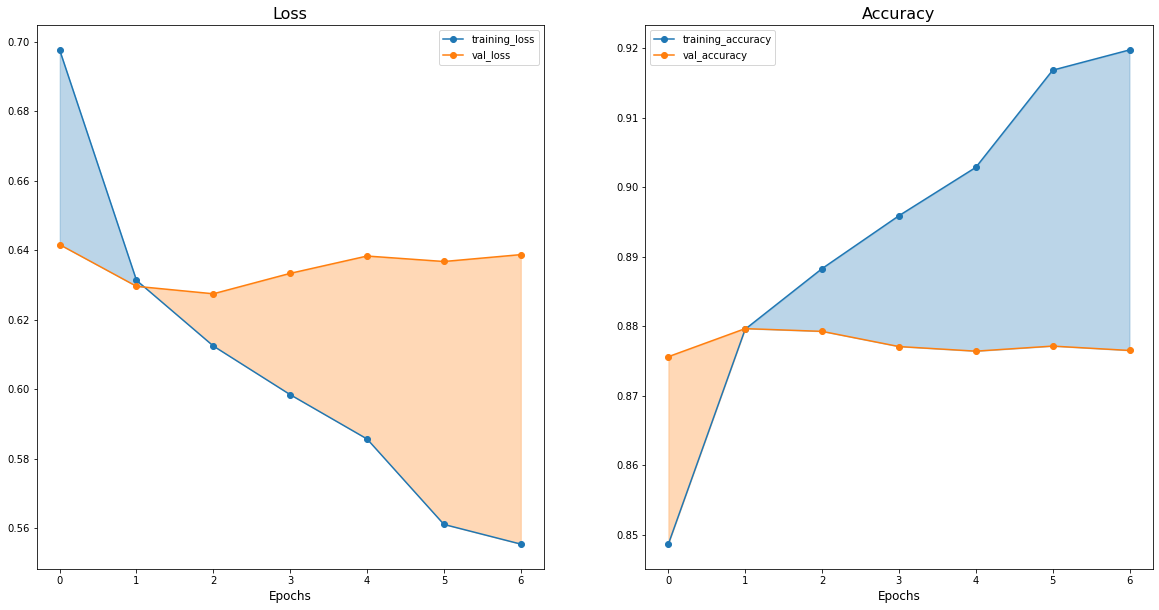

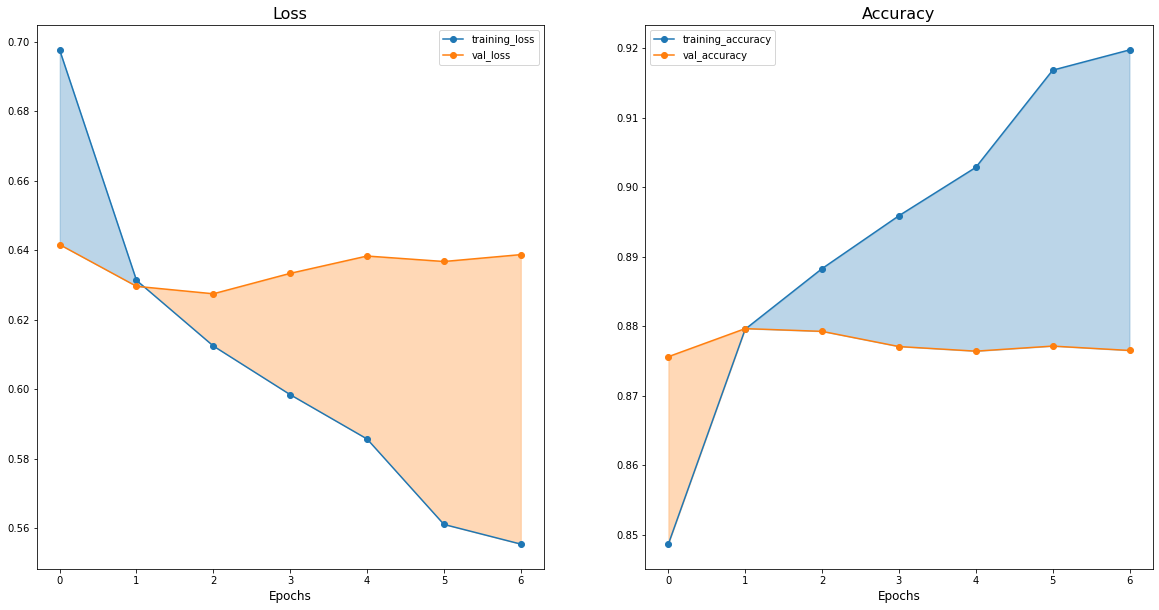

In [97]:
model_quality_viz(model_history)

Errrr, I don't know what did I fuck up, but it shows twice. But oh well...

In [103]:
from sklearn.metrics import classification_report
classification_report(encoded_val_labels, val_predictions, target_names=class_names)
classification_report

<function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>

<function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>

In [105]:
print(classification_report(encoded_val_labels, val_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.71      0.84      0.77      3449
 CONCLUSIONS       0.91      0.92      0.92      4582
     METHODS       0.92      0.92      0.92      9964
   OBJECTIVE       0.75      0.54      0.63      2376
     RESULTS       0.92      0.91      0.91      9841

    accuracy                           0.88     30212
   macro avg       0.84      0.83      0.83     30212
weighted avg       0.88      0.88      0.88     30212

              precision    recall  f1-score   support

  BACKGROUND       0.71      0.84      0.77      3449
 CONCLUSIONS       0.91      0.92      0.92      4582
     METHODS       0.92      0.92      0.92      9964
   OBJECTIVE       0.75      0.54      0.63      2376
     RESULTS       0.92      0.91      0.91      9841

    accuracy                           0.88     30212
   macro avg       0.84      0.83      0.83     30212
weighted avg       0.88      0.88      0.88     30212



Jesus! Why it so shit... I just wanna see the report!

In [107]:
print(classification_report(encoded_test_labels, test_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.72      0.84      0.78      3621
 CONCLUSIONS       0.91      0.92      0.91      4571
     METHODS       0.91      0.92      0.92      9897
   OBJECTIVE       0.74      0.54      0.62      2333
     RESULTS       0.91      0.90      0.91      9713

    accuracy                           0.87     30135
   macro avg       0.84      0.82      0.83     30135
weighted avg       0.87      0.87      0.87     30135

              precision    recall  f1-score   support

  BACKGROUND       0.72      0.84      0.78      3621
 CONCLUSIONS       0.91      0.92      0.91      4571
     METHODS       0.91      0.92      0.92      9897
   OBJECTIVE       0.74      0.54      0.62      2333
     RESULTS       0.91      0.90      0.91      9713

    accuracy                           0.87     30135
   macro avg       0.84      0.82      0.83     30135
weighted avg       0.87      0.87      0.87     30135



In [109]:
# print(classification_report(encoded_train_labels, train_predictions, target_names=class_names))

To better understand the performance, we need to introduce other coefficients, such as Matthew's Correlation Coefficient.

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

I think we can use more from:

> https://scikit-learn.org/stable/modules/model_evaluation.html


In [136]:
def more_performance_info_val(y_true, y_pred, y_probabilities):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    balanced_accuracy = round(balanced_accuracy_score(y_true, y_pred), 5)
    top_3_accuracy = round(top_k_accuracy_score(y_true, y_probabilities, k=3), 5)
#     average_precision = round(average_precision_score(y_true, y_probabilities), 5)
# ValueError: multiclass format is not supported
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(encoded_val_labels, 
                                                                                 val_predictions, 
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    print(f'balanced_accuracy_score:\t\t{balanced_accuracy}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy}\n')
#     print('_____________________________________________')
#     print(f'average_precision_score:\t{average_precision}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
    print('=============================================')
    
    return

In [137]:
def more_performance_info_test(y_true, y_pred, y_probabilities):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    balanced_accuracy = round(balanced_accuracy_score(y_true, y_pred), 5)
    top_3_accuracy = round(top_k_accuracy_score(y_true, y_probabilities, k=3), 5)
#     average_precision = round(average_precision_score(y_true, y_probabilities), 5)
# ValueError: multiclass format is not supported
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(encoded_test_labels, 
                                                                                 test_predictions, 
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    print(f'balanced_accuracy_score:\t\t{balanced_accuracy}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy}\n')
#     print('_____________________________________________')
#     print(f'average_precision_score:\t{average_precision}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
    print('=============================================')
    
    return

In [138]:
more_performance_info_val(encoded_val_labels, val_predictions, val_probabilities)


Performance Metrics:

accuracy_score:		0.87925

_____________________________________________
balanced_accuracy_score:		0.82713

_____________________________________________
top_3_accuracy_score:	0.99484

_____________________________________________
precision_score:	0.87987

_____________________________________________
recall_score:		0.87925

_____________________________________________
f1_score:		0.8775

_____________________________________________
matthews_corrcoef:	0.83785


Performance Metrics:

accuracy_score:		0.87925

_____________________________________________
balanced_accuracy_score:		0.82713

_____________________________________________
top_3_accuracy_score:	0.99484

_____________________________________________
precision_score:	0.87987

_____________________________________________
recall_score:		0.87925

_____________________________________________
f1_score:		0.8775

_____________________________________________
matthews_corrcoef:	0.83785



In [139]:
more_performance_info_test(encoded_test_labels, test_predictions, test_probabilities)


Performance Metrics:

accuracy_score:		0.8741

_____________________________________________
balanced_accuracy_score:		0.82272

_____________________________________________
top_3_accuracy_score:	0.99469

_____________________________________________
precision_score:	0.87403

_____________________________________________
recall_score:		0.8741

_____________________________________________
f1_score:		0.87231

_____________________________________________
matthews_corrcoef:	0.8312


Performance Metrics:

accuracy_score:		0.8741

_____________________________________________
balanced_accuracy_score:		0.82272

_____________________________________________
top_3_accuracy_score:	0.99469

_____________________________________________
precision_score:	0.87403

_____________________________________________
recall_score:		0.8741

_____________________________________________
f1_score:		0.87231

_____________________________________________
matthews_corrcoef:	0.8312



Now, we try to get the confusion matrix.

In [141]:
def confusion_matrix_info(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=11): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True,
        annot_kws={"size": text_size},
        fmt='d',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    
    # Plot confusion matrix
    plt.show()
    
    return

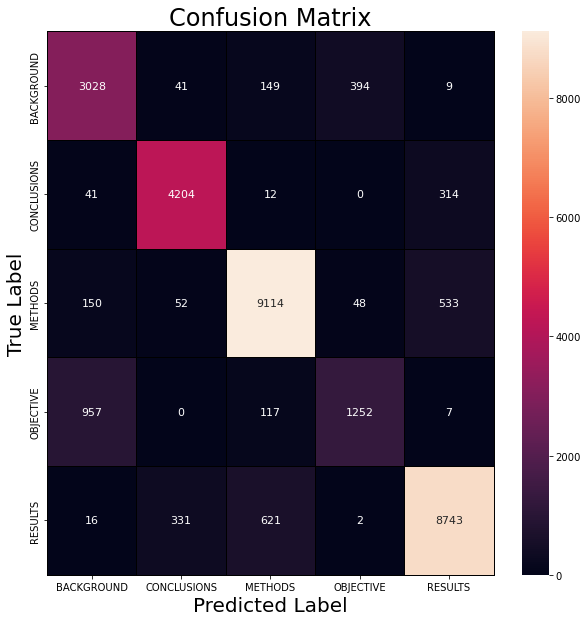

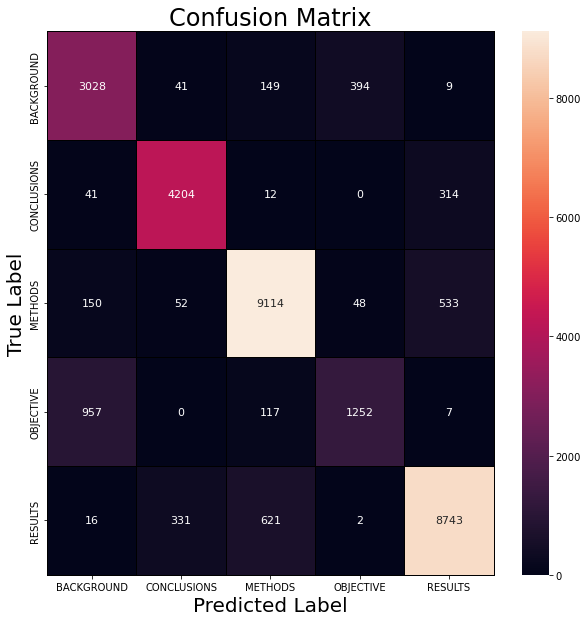

In [142]:
confusion_matrix_info(
    encoded_test_labels, 
    test_predictions, 
    figsize=(10, 10), 
    classes=list(class_names))

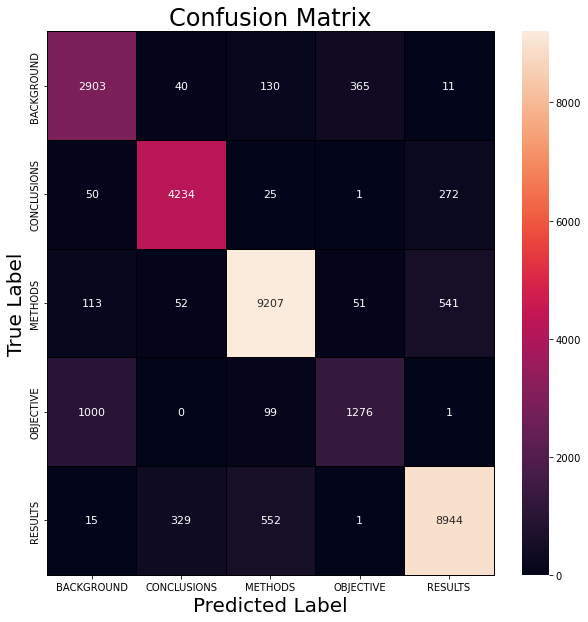

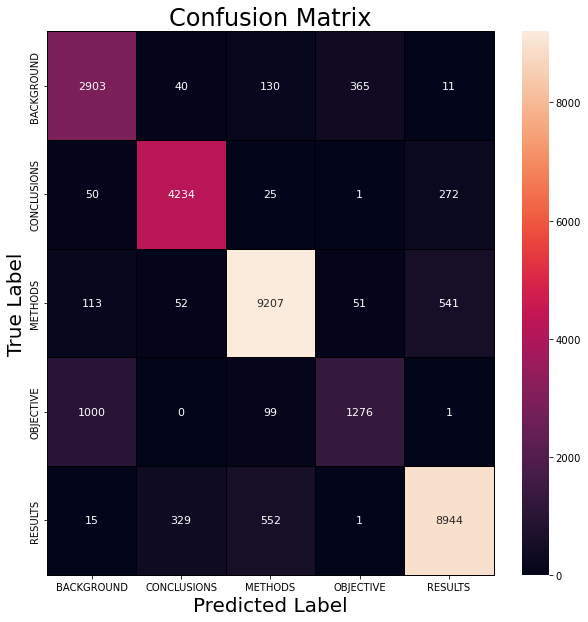

In [143]:
confusion_matrix_info(
    encoded_val_labels, 
    val_predictions, 
    figsize=(10, 10), 
    classes=list(class_names))

This leaves room for improvement, but I need to think through this in order to figure out a way.

In [146]:
# Get top 3 predictions
top_3_values, top_3_indices = tf.nn.top_k(test_probabilities, k=3)

In [147]:
df_test_pred = df_test.copy()

# Best
df_test_pred['prediction'] = [class_names[_] for _ in top_3_indices[:, 0]]
df_test_pred['probability'] = list(top_3_values[:, 0].numpy())

# Second Best
df_test_pred['prediction_2'] = [class_names[_] for _ in top_3_indices[:, 1]]
df_test_pred['probability_2'] = list(top_3_values[:, 1].numpy())

# Third Best
df_test_pred['prediction_3'] = [class_names[_] for _ in top_3_indices[:, 2]]
df_test_pred['probability_3'] = list(top_3_values[:, 2].numpy())

In [148]:
df_test_pred.head(10)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target,prediction,probability,prediction_2,probability_2,prediction_3,probability_3
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND,OBJECTIVE,0.501218,BACKGROUND,0.430140,CONCLUSIONS,0.037042
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS,OBJECTIVE,0.359137,BACKGROUND,0.346803,METHODS,0.174690
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS,METHODS,0.860923,RESULTS,0.078866,CONCLUSIONS,0.023827
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS,RESULTS,0.621096,METHODS,0.304449,CONCLUSIONS,0.026664
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS,RESULTS,0.836429,METHODS,0.060740,BACKGROUND,0.047153
5,24845963,24845963_5_9,When mean hemodynamic profiles were compared i...,5,9,5_9,RESULTS,RESULTS,0.883396,CONCLUSIONS,0.032052,BACKGROUND,0.030767
6,24845963,24845963_6_9,Multivariable analyses revealed that patients ...,6,9,6_9,RESULTS,RESULTS,0.923562,OBJECTIVE,0.033548,BACKGROUND,0.021746
7,24845963,24845963_7_9,Abnormal LFTs are common in the ADHF populatio...,7,9,7_9,CONCLUSIONS,CONCLUSIONS,0.946475,RESULTS,0.018071,BACKGROUND,0.013389
8,24845963,24845963_8_9,Elevated MELD-XI scores are associated with po...,8,9,8_9,CONCLUSIONS,CONCLUSIONS,0.960081,OBJECTIVE,0.013907,BACKGROUND,0.012444
9,24469619,24469619_0_13,Minimally invasive endovascular aneurysm repai...,0,13,0_13,BACKGROUND,BACKGROUND,0.606870,OBJECTIVE,0.323243,CONCLUSIONS,0.024652


,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target,prediction,probability,prediction_2,probability_2,prediction_3,probability_3
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND,OBJECTIVE,0.501218,BACKGROUND,0.430140,CONCLUSIONS,0.037042
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS,OBJECTIVE,0.359137,BACKGROUND,0.346803,METHODS,0.174690
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS,METHODS,0.860923,RESULTS,0.078866,CONCLUSIONS,0.023827
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS,RESULTS,0.621096,METHODS,0.304449,CONCLUSIONS,0.026664
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS,RESULTS,0.836429,METHODS,0.060740,BACKGROUND,0.047153
5,24845963,24845963_5_9,When mean hemodynamic profiles were compared i...,5,9,5_9,RESULTS,RESULTS,0.883396,CONCLUSIONS,0.032052,BACKGROUND,0.030767
6,24845963,24845963_6_9,Multivariable analyses revealed that patients ...,6,9,6_9,RESULTS,RESULTS,0.923562,OBJECTIVE,0.033548,BACKGROUND,0.021746
7,24845963,24845963_7_9,Abnormal LFTs are common in the ADHF populatio...,7,9,7_9,CONCLUSIONS,CONCLUSIONS,0.946475,RESULTS,0.018071,BACKGROUND,0.013389
8,24845963,24845963_8_9,Elevated MELD-XI scores are associated with po...,8,9,8_9,CONCLUSIONS,CONCLUSIONS,0.960081,OBJECTIVE,0.013907,BACKGROUND,0.012444
9,24469619,24469619_0_13,Minimally invasive endovascular aneurysm repai...,0,13,0_13,BACKGROUND,BACKGROUND,0.606870,OBJECTIVE,0.323243,CONCLUSIONS,0.024652


# Z. Thoughts

https://www.kaggle.com/competitions/alta-nicta-challenge2/data?select=train.csv

We should try on this as well, or use this as a real-world test example.

In [160]:
df_most_accurate = df_test_pred.loc[df_test_pred.target == df_test_pred.prediction].sort_values('probability', inplace=False, ascending=False)

In [161]:
df_most_accurate.head(10)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target,prediction,probability,prediction_2,probability_2,prediction_3,probability_3
13672,25512466,25512466_0_13,To determine whether maternal allopurinol trea...,0,13,0_13,OBJECTIVE,OBJECTIVE,0.998366,CONCLUSIONS,0.001632,RESULTS,8.104539e-07
27177,24814090,24814090_11_12,Genentech .,11,12,11_12,BACKGROUND,BACKGROUND,0.996491,CONCLUSIONS,0.002197,OBJECTIVE,8.799052e-04
24199,25835160,25835160_1_15,To evaluate the effectiveness and tolerance of...,1,15,1_15,OBJECTIVE,OBJECTIVE,0.996116,RESULTS,0.001988,CONCLUSIONS,1.344888e-03
16312,25112009,25112009_0_14,To explore the feasibility and safety of dexme...,0,14,0_14,OBJECTIVE,OBJECTIVE,0.995888,CONCLUSIONS,0.002273,RESULTS,1.591301e-03
13889,24440365,24440365_0_14,To determine whether providing a controlled re...,0,14,0_14,OBJECTIVE,OBJECTIVE,0.995108,CONCLUSIONS,0.003178,RESULTS,6.712419e-04
18201,24847084,24847084_15_18,An online SE game among clinicians generated a...,15,18,15_18,CONCLUSIONS,CONCLUSIONS,0.994204,BACKGROUND,0.002450,OBJECTIVE,2.357870e-03
15351,25801579,25801579_0_15,To compare the effectiveness and acceptability...,0,15,0_15,OBJECTIVE,OBJECTIVE,0.993618,RESULTS,0.004040,CONCLUSIONS,1.552870e-03
11854,25815570,25815570_0_10,To determine the effect of dantrolene premedic...,0,10,0_10,OBJECTIVE,OBJECTIVE,0.993087,CONCLUSIONS,0.003212,RESULTS,3.143610e-03
18563,24664198,24664198_12_13,See the Instructions for Authors for a complet...,12,13,12_13,METHODS,METHODS,0.992804,CONCLUSIONS,0.003318,OBJECTIVE,2.662991e-03
2191,24601188,24601188_0_9,To compare the extraction time and infection r...,0,9,0_9,OBJECTIVE,OBJECTIVE,0.992793,RESULTS,0.004725,CONCLUSIONS,1.641999e-03


,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target,prediction,probability,prediction_2,probability_2,prediction_3,probability_3
13672,25512466,25512466_0_13,To determine whether maternal allopurinol trea...,0,13,0_13,OBJECTIVE,OBJECTIVE,0.998366,CONCLUSIONS,0.001632,RESULTS,8.104539e-07
27177,24814090,24814090_11_12,Genentech .,11,12,11_12,BACKGROUND,BACKGROUND,0.996491,CONCLUSIONS,0.002197,OBJECTIVE,8.799052e-04
24199,25835160,25835160_1_15,To evaluate the effectiveness and tolerance of...,1,15,1_15,OBJECTIVE,OBJECTIVE,0.996116,RESULTS,0.001988,CONCLUSIONS,1.344888e-03
16312,25112009,25112009_0_14,To explore the feasibility and safety of dexme...,0,14,0_14,OBJECTIVE,OBJECTIVE,0.995888,CONCLUSIONS,0.002273,RESULTS,1.591301e-03
13889,24440365,24440365_0_14,To determine whether providing a controlled re...,0,14,0_14,OBJECTIVE,OBJECTIVE,0.995108,CONCLUSIONS,0.003178,RESULTS,6.712419e-04
18201,24847084,24847084_15_18,An online SE game among clinicians generated a...,15,18,15_18,CONCLUSIONS,CONCLUSIONS,0.994204,BACKGROUND,0.002450,OBJECTIVE,2.357870e-03
15351,25801579,25801579_0_15,To compare the effectiveness and acceptability...,0,15,0_15,OBJECTIVE,OBJECTIVE,0.993618,RESULTS,0.004040,CONCLUSIONS,1.552870e-03
11854,25815570,25815570_0_10,To determine the effect of dantrolene premedic...,0,10,0_10,OBJECTIVE,OBJECTIVE,0.993087,CONCLUSIONS,0.003212,RESULTS,3.143610e-03
18563,24664198,24664198_12_13,See the Instructions for Authors for a complet...,12,13,12_13,METHODS,METHODS,0.992804,CONCLUSIONS,0.003318,OBJECTIVE,2.662991e-03
2191,24601188,24601188_0_9,To compare the extraction time and infection r...,0,9,0_9,OBJECTIVE,OBJECTIVE,0.992793,RESULTS,0.004725,CONCLUSIONS,1.641999e-03
